In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

In [2]:
# Load in all the data
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")
cal_df = pd.read_parquet("../validationB_v3.parquet")
test_df = pd.read_parquet("../test_v3.parquet")

In [3]:
# check shapes of the dataframes
print(train_df.shape)
print(val_df.shape)
print(cal_df.shape)
print(test_df.shape)

(112768, 791)
(24164, 791)
(24164, 791)
(40274, 791)


In [4]:
# separate the target from the features
def split_features_target(df, target='match'):
    return df.drop(columns=[target]), df[target]

X_train, y_train = split_features_target(train_df)
X_val, y_val = split_features_target(val_df)
X_cal, y_cal = split_features_target(cal_df)
X_test, y_test = split_features_target(test_df)


In [5]:
dfs = [X_train, X_val, X_cal, X_test]

for df in dfs:
    # Calculate review_span in days
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)
    
    # Convert missing_price to int
    df['missing_price'] = df['missing_price'].astype(int)
    
    # Calculate product_lifespan in days
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)
    
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

# Print shapes
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_cal: {X_cal.shape}, X_test: {X_test.shape}")


X_train: (112768, 785), X_val: (24164, 785), X_cal: (24164, 785), X_test: (40274, 785)


Preprocessing PCA

In [6]:
def make_transformer(df,r, s, drop_first=True):
    rev_cols  = [c for c in df if c.startswith("embedding_")]
    summ_cols = [c for c in df if c.startswith("embed_")]
    numeric_cols  = [c for c in df if c not in rev_cols+summ_cols+["category"]]

    rev_pipe  = ("drop" if r == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=r,random_state=42))]))
    sum_pipe  = ("drop" if s == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=s,random_state=42))]))

    return ColumnTransformer(
        [('num', StandardScaler(), numeric_cols),
         ('cat', OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False), ["category"]),
         ('rev', rev_pipe,  rev_cols),
         ('sum', sum_pipe,  summ_cols)
        ]).set_output(transform="pandas")

In [7]:
# transform all of the data 
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_cal_proc = preprocessor.transform(X_cal)
X_test_proc = preprocessor.transform(X_test)

In [8]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

Models to Fit **Without** Categorical Features

In [9]:
# initialize the models found in hyperparameter tuning
model_2_wo_cat = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_7_wo_cat = RandomForestClassifier(n_estimators=300,
                                 class_weight={0:1.0, 1:250.0},
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)
model_8_wo_cat = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=-3)

Models to Fit **With** Categorical Features

In [10]:
# initialize the models found in hyperparameter tuning
model_4 = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)
model_7 = RandomForestClassifier(n_estimators=300,
                                 class_weight={0:1.0, 1:250.0},
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)
model_8 = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=-3)

model_9 = RandomForestClassifier(n_estimators=300,
                                 class_weight='balanced',
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)

model_10 = XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.05,
    subsample=0.6, colsample_bytree=1.0,
    reg_alpha=0.0, reg_lambda=0.5,
    scale_pos_weight=250.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=-3)


Train the Models

In [11]:
# drop categorical columns
X_train_wo_cat_proc = X_train_proc.drop(columns=cat_cols)
X_val_wo_cat_proc = X_val_proc.drop(columns=cat_cols)
X_cal_wo_cat_proc = X_cal_proc.drop(columns=cat_cols)
X_test_wo_cat_proc = X_test_proc.drop(columns=cat_cols)

In [12]:
# fit models
# models without cat_cols
model_2_wo_cat.fit(X_train_wo_cat_proc, y_train)
model_7_wo_cat.fit(X_train_wo_cat_proc, y_train)
model_8_wo_cat.fit(X_train_wo_cat_proc, y_train)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:36:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-3, num_parallel_tree=None, random_state=42, ...)

In [13]:
# fit models
# models with cat_cols
model_4.fit(X_train_proc, y_train)
model_5.fit(X_train_proc, y_train)
model_6.fit(X_train_proc, y_train)
model_7.fit(X_train_proc, y_train)
model_8.fit(X_train_proc, y_train)
model_9.fit(X_train_proc, y_train)
model_10.fit(X_train_proc, y_train)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:41:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-3, num_parallel_tree=None, random_state=42, ...)

Calibrate the Models

In [ ]:
# wrap already-fitted model
cal_model_2_wo_cat = CalibratedClassifierCV(estimator=model_2_wo_cat, method='sigmoid', cv='prefit')
cal_model_7_wo_cat = CalibratedClassifierCV(estimator=model_7_wo_cat, method='sigmoid', cv='prefit')
cal_model_8_wo_cat = CalibratedClassifierCV(estimator=model_8_wo_cat, method='sigmoid', cv='prefit')

cal_model_4 = CalibratedClassifierCV(estimator=model_4, method='sigmoid', cv='prefit')
cal_model_5 = CalibratedClassifierCV(estimator=model_5, method='sigmoid', cv='prefit')
cal_model_6 = CalibratedClassifierCV(estimator=model_6, method='sigmoid', cv='prefit')
cal_model_7 = CalibratedClassifierCV(estimator=model_7, method='sigmoid', cv='prefit')
cal_model_8 = CalibratedClassifierCV(estimator=model_8, method='sigmoid', cv='prefit' )
cal_model_9 = CalibratedClassifierCV(estimator=model_9, method='sigmoid', cv='prefit' )
cal_model_10 = CalibratedClassifierCV(estimator=model_10, method='sigmoid', cv='prefit' )


# fit calibration model on calibration set
cal_model_4.fit(X_cal_proc, y_cal)
cal_model_5.fit(X_cal_proc, y_cal)
cal_model_6.fit(X_cal_proc, y_cal)
cal_model_7.fit(X_cal_proc, y_cal)
cal_model_8.fit(X_cal_proc, y_cal)
cal_model_9.fit(X_cal_proc, y_cal)
cal_model_10.fit(X_cal_proc, y_cal)
cal_model_2_wo_cat.fit(X_cal_wo_cat_proc, y_cal)
cal_model_7_wo_cat.fit(X_cal_wo_cat_proc, y_cal)
cal_model_8_wo_cat.fit(X_cal_wo_cat_proc, y_cal)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.6,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.01, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=5,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=-3,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

Manual 'Voting' Classifier

**With** Categories

In [44]:
# predict probabilities on calibrated model
proba_lr = cal_model_5.predict_proba(X_test_proc)
proba_rf = cal_model_7.predict_proba(X_test_proc)
proba_xgb = cal_model_8.predict_proba(X_test_proc)

# take average to get 'voting classifier'
avg_proba = (proba_lr + proba_rf + proba_xgb) / 3

In [45]:
# use predetermined threshold coming from imbalance weights
threshold = 1/146

# probability for class 1
proba_class1 = avg_proba[:, 1]

# apply the threshold
preds = (proba_class1 >= threshold).astype(int)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       1.00      0.73      0.84     40000
           1       0.02      0.81      0.04       274

    accuracy                           0.73     40274
   macro avg       0.51      0.77      0.44     40274
weighted avg       0.99      0.73      0.84     40274



Text(0, 0.5, 'True Fraction of Positives')

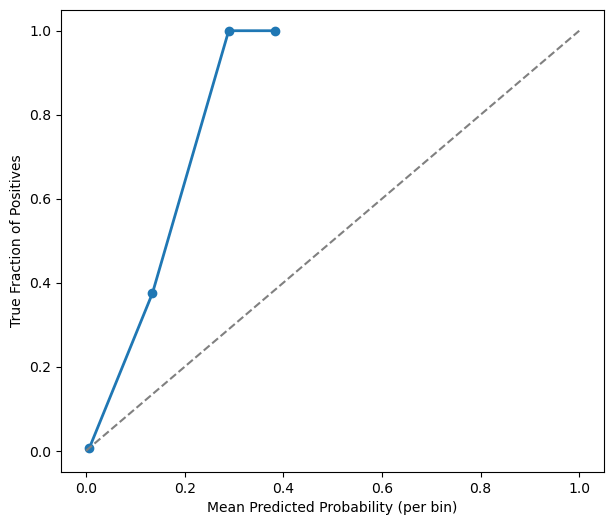

In [46]:
# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, avg_proba[:,1], n_bins=10, strategy='uniform')

# Optional: Compute bin centers and counts for potential histogram overlay
# bin_edges = np.linspace(0, 1, 11)
# bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
# bin_counts, _ = np.histogram(proba_class1, bins=bin_edges)

# Plot calibration curve
plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('True Fraction of Positives')

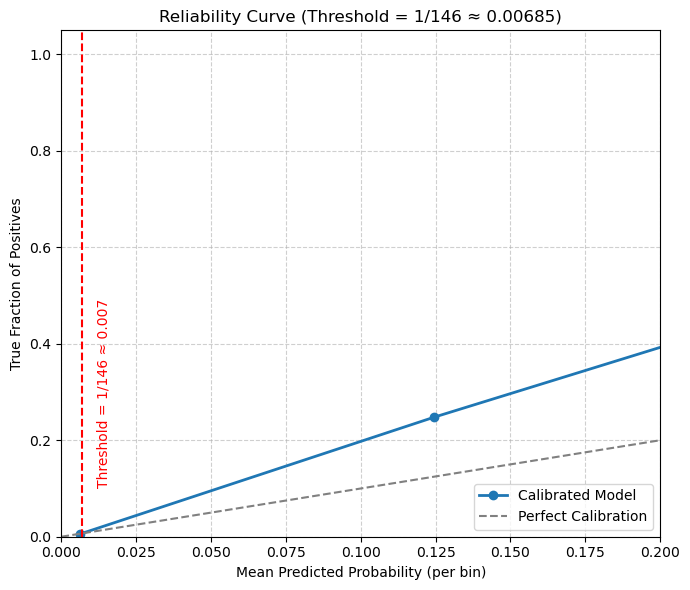

In [37]:
# Set the threshold
threshold = 1 / 146 

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, proba_class1, n_bins=10, strategy='uniform')

# Optional: Compute bin centers and counts for potential histogram overlay
# bin_edges = np.linspace(0, 1, 11)
# bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
# bin_counts, _ = np.histogram(proba_class1, bins=bin_edges)

# Plot calibration curve
plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

# Vertical threshold line
plt.axvline(x=threshold, color='red', linestyle='--')
plt.text(threshold + 0.005, 0.1, f'Threshold = 1/146 ≈ {threshold:.3f}', color='red', rotation=90, va='bottom')

# # Optional: Histogram overlay (commented)
# ax = plt.gca()
# ax2 = ax.twinx()
# ax2.bar(bin_centers, bin_counts, width=0.08, color='lightgray', alpha=0.3, label='Bin Support')
# ax2.set_ylabel('Sample Count per Bin')

# Zoom in for better visibility of low-threshold region
plt.xlim(0, 0.2)
plt.ylim(0, 1.05)

# Labels and styling
plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('True Fraction of Positives')
plt.title('Reliability Curve (Threshold = 1/146 ≈ 0.00685)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


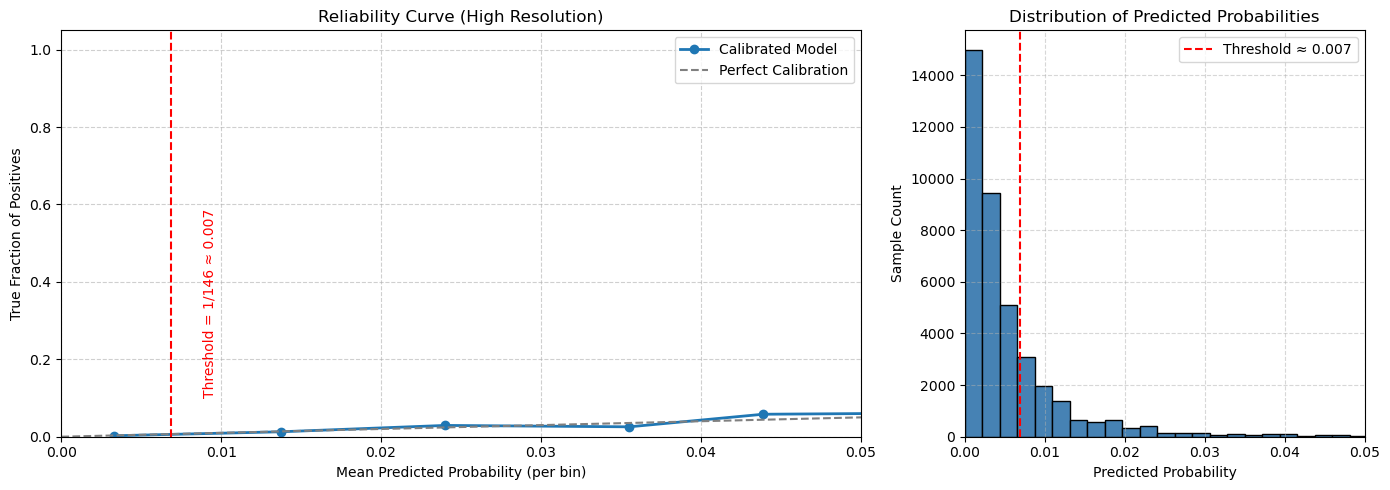

In [38]:
# Define threshold
threshold = 1 / 146  # ≈ 0.00685

# Calibration curve with high-resolution bins
n_bins = 100
prob_true, prob_pred = calibration_curve(y_test, proba_class1, n_bins=n_bins, strategy='uniform')

# Create subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

### Plot 1: Reliability Curve ###
axs[0].plot(prob_pred, prob_true, marker='o', label='Calibrated Model', linewidth=2)
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

# Threshold line and annotation
axs[0].axvline(x=threshold, color='red', linestyle='--')
axs[0].text(threshold + 0.002, 0.1, f'Threshold = 1/146 ≈ {threshold:.3f}', color='red', rotation=90, va='bottom')

axs[0].set_xlim(0, 0.05)  # Zoom in for threshold visibility
axs[0].set_ylim(0, 1.05)
axs[0].set_xlabel('Mean Predicted Probability (per bin)')
axs[0].set_ylabel('True Fraction of Positives')
axs[0].set_title('Reliability Curve (High Resolution)')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

### Plot 2: Histogram of Predicted Probabilities ###
axs[1].hist(proba_class1, bins=100, color='steelblue', edgecolor='black')
axs[1].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ≈ {threshold:.3f}')
axs[1].set_xlim(0, 0.05)
axs[1].set_xlabel('Predicted Probability')
axs[1].set_ylabel('Sample Count')
axs[1].set_title('Distribution of Predicted Probabilities')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


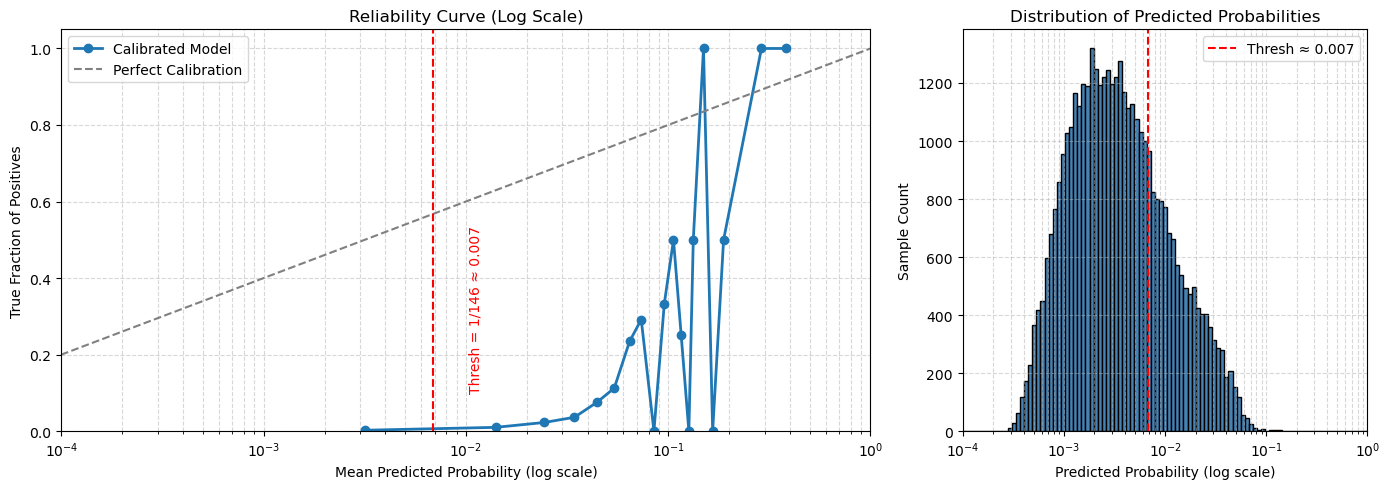

In [20]:
# Define threshold
threshold = 1 / 146  # ≈ 0.00685

# Calibration curve with high-resolution bins
n_bins = 100
prob_true, prob_pred = calibration_curve(y_test, proba_class1, n_bins=n_bins, strategy='uniform')

# Create subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

### Plot 1: Reliability Curve (Log scale) ###
axs[0].plot(prob_pred, prob_true, marker='o', label='Calibrated Model', linewidth=2)
axs[0].plot([1e-5, 1], [1e-5, 1], linestyle='--', color='gray', label='Perfect Calibration')  # Start from low

# Threshold line and annotation
axs[0].axvline(x=threshold, color='red', linestyle='--')
axs[0].text(threshold * 1.5, 0.1, f'Thresh = 1/146 ≈ {threshold:.3f}', color='red', rotation=90, va='bottom')

axs[0].set_xscale('log')
axs[0].set_xlim(1e-4, 1)  # Log scale bounds
axs[0].set_ylim(0, 1.05)
axs[0].set_xlabel('Mean Predicted Probability (log scale)')
axs[0].set_ylabel('True Fraction of Positives')
axs[0].set_title('Reliability Curve (Log Scale)')
axs[0].legend()
axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

### Plot 2: Histogram of Predicted Probabilities (Log scale) ###
axs[1].hist(proba_class1, bins=np.logspace(-4, 0, 100), color='steelblue', edgecolor='black')
axs[1].axvline(x=threshold, color='red', linestyle='--', label=f'Thresh ≈ {threshold:.3f}')
axs[1].set_xscale('log')
axs[1].set_xlim(1e-4, 1)
axs[1].set_xlabel('Predicted Probability (log scale)')
axs[1].set_ylabel('Sample Count')
axs[1].set_title('Distribution of Predicted Probabilities')
axs[1].legend()
axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Balanced Weight 'Voting Classifier'

In [39]:
# predict probabilities on calibrated model
proba_lr_bal = cal_model_4.predict_proba(X_test_proc)
proba_rf_bal = cal_model_9.predict_proba(X_test_proc)
proba_xgb_bal = cal_model_10.predict_proba(X_test_proc)

# take average to make 'voting classifier'
avg_proba_bal = (proba_lr_bal + proba_rf_bal + proba_xgb_bal) / 3

Text(0, 0.5, 'True Fraction of Positives')

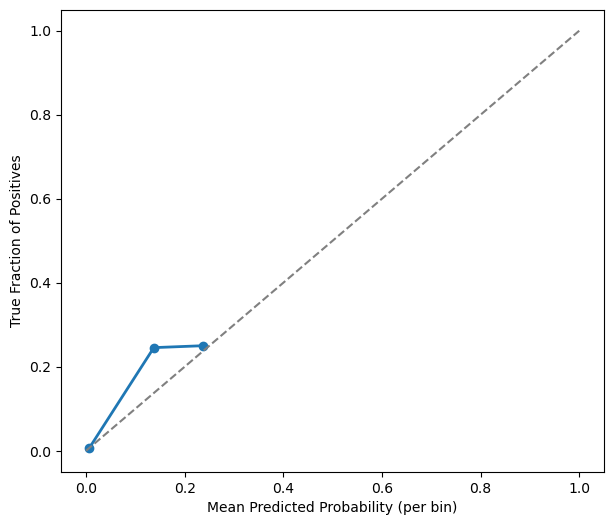

In [55]:
# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, avg_proba_bal[:,1], n_bins=10, strategy='uniform')

# Plot calibration curve
plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('True Fraction of Positives')

**Without** Categories

In [41]:
# predict probabilities on calibrated model
proba_lr_wo_cat = cal_model_2_wo_cat.predict_proba(X_test_wo_cat_proc)
proba_rf_wo_cat = cal_model_7_wo_cat.predict_proba(X_test_wo_cat_proc)
proba_xgb_wo_cat = cal_model_8_wo_cat.predict_proba(X_test_wo_cat_proc)

# take average to make 'voting classifier'
avg_proba_wo_cat = (proba_lr_wo_cat + proba_rf_wo_cat + proba_xgb_wo_cat) / 3

In [42]:
# pick a threshold
threshold = 1/146

# probability for class 1
proba_class1_wo_cat = avg_proba_wo_cat[:, 1]

# apply the threshold
preds_wo_cat = (proba_class1_wo_cat >= threshold).astype(int)
print(classification_report(y_test, preds_wo_cat))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85     40000
           1       0.02      0.77      0.04       274

    accuracy                           0.73     40274
   macro avg       0.51      0.75      0.44     40274
weighted avg       0.99      0.73      0.84     40274



Text(0, 0.5, 'True Fraction of Positives')

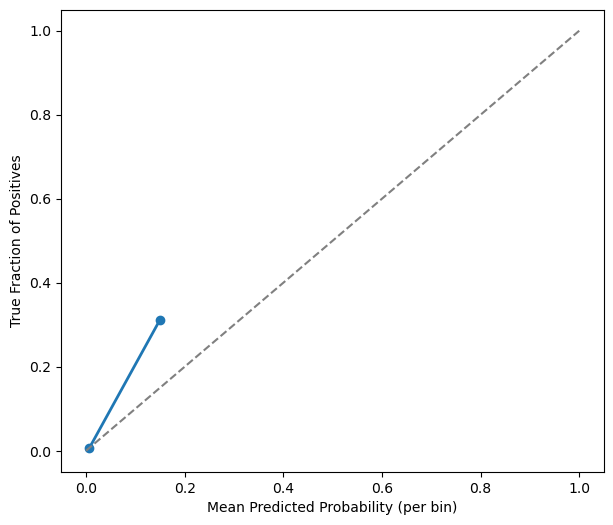

In [54]:
# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, avg_proba_wo_cat[:,1], n_bins=8, strategy='uniform')

# Plot calibration curve
plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('True Fraction of Positives')

Anamoly Detection

In [25]:
proba_series = pd.Series(proba_class1, name="P(class=1)")

# calculate the average predicted probability
mean_prob = proba_series.mean()

# Find anomalies: probabilities > average
anomalies = proba_series[proba_series > 10*mean_prob]

# Optionally inspect
print(f"Mean predicted P(class=1): {10*mean_prob:.4f}")
print(f"Number of anomalies (above mean): {len(anomalies)}")

# To view the anomalous rows with their indices and probabilities
# print(anomalies.sort_values(ascending=False).head())


Mean predicted P(class=1): 0.0681
Number of anomalies (above mean): 62


In [26]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba_class1)

# threshold for 90% precision
target_precision = 0.90
idx = next(i for i, p in enumerate(precision) if p >= target_precision)
best_thresh = thresholds[idx]

anomalies = proba_series[proba_series > best_thresh]
print(f"Threshold for ≥90% precision: {best_thresh:.4f}")

Threshold for ≥90% precision: 0.2892


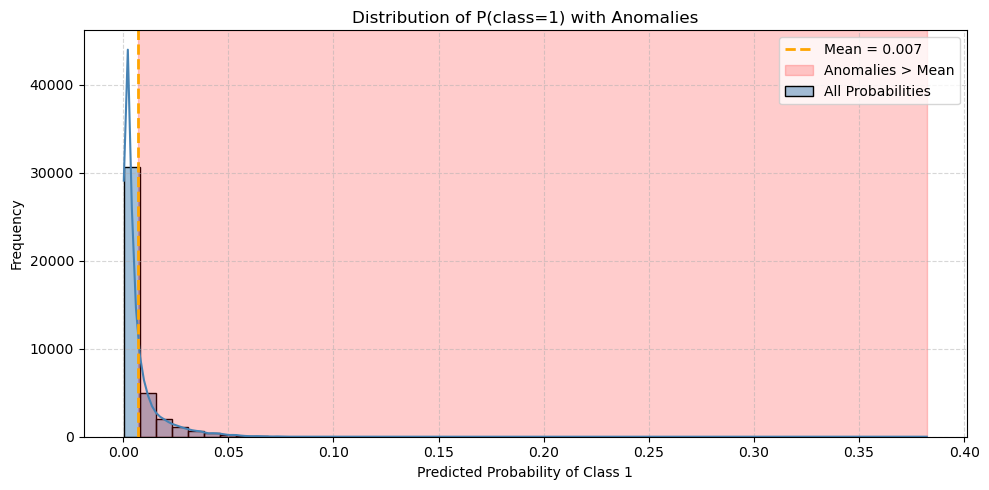

In [27]:
# proba_class1 = model.predict_proba(X_test)[:, 1]
proba_series = pd.Series(proba_class1, name="P(class=1)")
mean_prob = proba_series.mean()
anomalies = proba_series[proba_series > 10*mean_prob]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(proba_series, bins=50, kde=True, color='steelblue', edgecolor='black', label='All Probabilities')
plt.axvline(mean_prob, color='orange', linestyle='--', linewidth=2, label=f'Mean = {mean_prob:.3f}')
plt.axvspan(mean_prob, proba_series.max(), color='red', alpha=0.2, label='Anomalies > Mean')

# Styling
plt.title('Distribution of P(class=1) with Anomalies')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Anomaly threshold (90th percentile among true class 0): 0.0170
Number of flagged anomalies: 4000


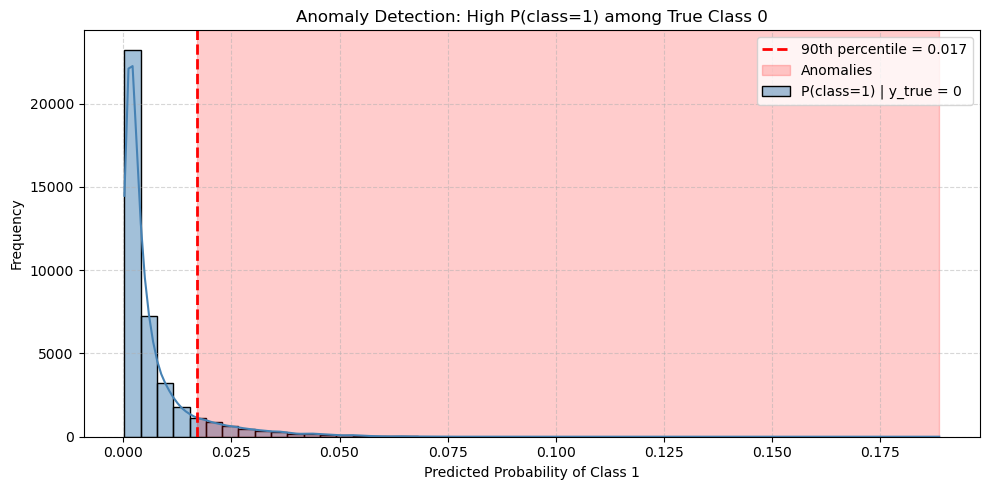

In [28]:
df = pd.DataFrame({
    'y_true': y_test,
    'proba_class1': proba_class1
})

# Filter to only true class = 0
df_negatives = df[df['y_true'] == 0]

# set anomaly threshold
threshold = df_negatives['proba_class1'].quantile(0.90)

# flag anomalies
anomalies = df_negatives[df_negatives['proba_class1'] > threshold]

print(f"Anomaly threshold (90th percentile among true class 0): {threshold:.4f}")
print(f"Number of flagged anomalies: {len(anomalies)}")

# plot 
plt.figure(figsize=(10, 5))
sns.histplot(df_negatives['proba_class1'], bins=50, kde=True, color='steelblue', edgecolor='black', label='P(class=1) | y_true = 0')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'90th percentile = {threshold:.3f}')
plt.axvspan(threshold, df_negatives['proba_class1'].max(), color='red', alpha=0.2, label='Anomalies')

plt.title('Anomaly Detection: High P(class=1) among True Class 0')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
import pandas as pd

# Assume these exist:
# proba_class1: 1D array or Series with predicted P(class=1)
# y_true: 1D array or Series with true labels (0 or 1)

# Convert to Series for convenience (if not already)
proba_series = pd.Series(proba_class1, name="P(class=1)")
y_true_series = pd.Series(y_test, name="true_label")

# Filter probabilities only where y_true == 0
proba_filtered = proba_series[y_true_series.values == 0]

# Calculate the average predicted probability for the filtered subset
mean_prob = proba_filtered.mean()

mean_prob_ten_times = 10*mean_prob

# Find anomalies: probabilities > average in the filtered subset
anomalies = proba_filtered[proba_filtered > mean_prob_ten_times]

# Print results
print(f"Mean predicted P(class=1) for y_true=0: {mean_prob:.4f}")
print(f"Mean predicted P(class=1) for y_true=0: {mean_prob_ten_times:.4f}")
print(f"Number of anomalies (above mean) with y_true=0: {len(anomalies)}")

# View the anomalous probabilities sorted descending (with original indices)
#print(anomalies.sort_values(ascending=False).head())


Mean predicted P(class=1) for y_true=0: 0.0066
Mean predicted P(class=1) for y_true=0: 0.0663
Number of anomalies (above mean) with y_true=0: 50


In [30]:
import numpy as np
import pandas as pd

# Assume these exist:
# proba_class1: 1D array or Series with predicted P(class=1)
# y_test: 1D array or Series with true labels (0 or 1)

# Convert to Series with aligned index
proba_series = pd.Series(proba_class1).reset_index(drop=True)
y_true_series = pd.Series(y_test).reset_index(drop=True)

# Filter only true negatives (y_true == 0)
proba_filtered = proba_series[y_true_series == 0]

# Compute mean probability for y_true == 0
mean_prob = proba_filtered.mean()
mean_prob_ten_times = 10 * mean_prob

# Find anomalies (flagged when predicted prob > threshold)
anomalies = proba_filtered[proba_filtered > mean_prob_ten_times]

# Compute percent of y_true==0 that were flagged
percent_flagged = len(anomalies) / len(proba_filtered) * 100

# Print summary
print(f"Mean predicted P(class=1) for y_true=0: {mean_prob:.4f}")
print(f"10x mean threshold: {mean_prob_ten_times:.4f}")
print(f"Anomalies (P > 10x mean) with y_true=0: {len(anomalies)}")
print(f"Percent of y_true=0 flagged as anomalies: {percent_flagged:.2f}%")


Mean predicted P(class=1) for y_true=0: 0.0066
10x mean threshold: 0.0663
Anomalies (P > 10x mean) with y_true=0: 50
Percent of y_true=0 flagged as anomalies: 0.12%
